In [14]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from nltk.corpus import words
from scipy import spatial, stats
from scipy.stats import pearsonr, spearmanr
from collections import Counter, defaultdict
from statistics import mean, stdev
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import geopandas
from shapely.geometry import Point
import mapclassify    
import json
import copy
import csv
import sys
import re
import math
import random
import time

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    #sys.stdout.write(str(d))
    sys.stdout.write('%d' % d)
    sys.stdout.flush()

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

## Read in Data

### 1. year, socName, N posts, education

In [8]:
# JOB YEAR NPOSTS
jyn = defaultdict(lambda:defaultdict(lambda:0))
yjn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt',
          'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            jyn[job][year] = num
            yjn[year][job] = num
            if edu != 'nan' and edu != 'nan\n': 
                if float(edu) > 0:
                    jye[job][year] = float(edu)

### 2. socName - meta (ave. pay, ave. edu, 2-digits soc group)

In [54]:
oe={}
op={}
ocg={}
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/socName_aveMedianPay_aveMinEdu_socGroup.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        job = line_lst[0]
        op[job] = float(line_lst[1])
        oe[job] = float(line_lst[2])
        ocg[job] = line_lst[3]
# SOC GROUP--6 digit SOC
go=defaultdict(lambda:set())
for o in ocg:
    go[ocg[o]].add(o)

### 3. year - socName - skill freq

In [9]:
# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf

In [10]:
# job - top 5% defining skills
jys = defaultdict(lambda:defaultdict(lambda:[]))
syj = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year].append(skill)
                syj[skill][year].append(job)
        if len(jys[job][year]) < 5:
            del jys[job][year]
            fulllist = syj[skill][year]
            syj[skill][year] = [value for value in fulllist if value != job]

In [15]:
# job - SKILL NUMBER
osn = {}
for job in jys:
    snlst = []
    for yr in jys[job]:
        if len(jys[job][yr]) != 0:
            snlst.append(len(jys[job][yr]))
    if snlst:
        osn[job] = round(np.mean(snlst)) 
osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

### 4(1)a. Large company year - socName - skill freq

In [9]:
# Large Company JOB-SKILL DATA
# without filtering the skills
lcyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/lc10_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    lcyjas[year][job][skill] = tfidf

# filter the defining skills
lcjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in lcyjas:
    for job in lcyjas[year]:
        threshold = np.quantile(list(lcyjas[year][job].values()), [0.95])
        for skill in lcyjas[year][job]:
            if lcyjas[year][job][skill] > threshold:
                lcjys[job][year].append(skill)
        if len(lcjys[job][year]) < 5:
            del lcjys[job][year]

In [10]:
# large company SKILL NUMBER
lcosn = {}
for job in lcjys:
    snlst = []
    for yr in lcjys[job]:
        if len(lcjys[job][yr]) != 0:
            snlst.append(len(lcjys[job][yr]))
    if snlst:
        lcosn[job] = round(np.mean(snlst)) 
lcosn = dict(sorted(lcosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(1)b. Small company year - socName - skill freq

In [11]:
# Small Company JOB-SKILL DATA
# without filtering the skills
scyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/sc10_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    scyjas[year][job][skill] = tfidf

# filter the defining skills
scjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in scyjas:
    for job in scyjas[year]:
        threshold = np.quantile(list(scyjas[year][job].values()), [0.95])
        for skill in scyjas[year][job]:
            if scyjas[year][job][skill] >= threshold:
                scjys[job][year].append(skill)
        if len(scjys[job][year]) < 5:
            del scjys[job][year]  

In [12]:
# small company SKILL NUMBER
scosn = {}
for job in scjys:
    snlst = []
    for yr in scjys[job]:
        if len(scjys[job][yr]) != 0:
            snlst.append(len(scjys[job][yr]))
    if snlst:
        scosn[job] = round(np.mean(snlst)) 
scosn = dict(sorted(scosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(2)a. Large Market year - socName - skill freq 

In [32]:
# Large Company JOB-SKILL DATA
# without filtering the skills
llocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/lcz_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    llocyjas[year][job][skill] = tfidf

# filter the defining skills
llocjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in llocyjas:
    for job in llocyjas[year]:
        threshold = np.quantile(list(llocyjas[year][job].values()), [0.95])
        for skill in llocyjas[year][job]:
            if llocyjas[year][job][skill] > threshold:
                llocjys[job][year].append(skill)
        if len(llocjys[job][year]) < 5:
            del llocjys[job][year]

In [33]:
# large location SKILL NUMBER
llocosn = {}
for job in llocjys:
    snlst = []
    for yr in llocjys[job]:
        if len(llocjys[job][yr]) != 0:
            snlst.append(len(llocjys[job][yr]))
    if snlst:
        llocosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
llocosn = dict(sorted(llocosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(2)b. Small Market year - socName - skill freq 

In [37]:
# Small market JOB-SKILL DATA
# without filtering the skills
slocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/scz_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    slocyjas[year][job][skill] = tfidf

# filter the defining skills
slocjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in slocyjas:
    for job in slocyjas[year]:
        threshold = np.quantile(list(slocyjas[year][job].values()), [0.95])
        for skill in slocyjas[year][job]:
            if slocyjas[year][job][skill] >= threshold:
                slocjys[job][year].append(skill)
        if len(slocjys[job][year]) < 5:
            del slocjys[job][year]  

In [38]:
# small market SKILL NUMBER
slocosn = {}
for job in slocjys:
    snlst = []
    for yr in slocjys[job]:
        if len(slocjys[job][yr]) != 0:
            snlst.append(len(slocjys[job][yr]))
    if snlst:
        slocosn[job] = round(np.mean(snlst)) 
slocosn = dict(sorted(slocosn.items(), key=operator.itemgetter(1),reverse=True))

###  5. skill embedding (all years)

In [7]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

#### Job Vector

In [36]:
# 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

#### Job Vector Change 

In [37]:
# job stability from 2010 to 2018: dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

In [38]:
len(jyv), len(jtr)

(805, 727)

In [13]:
# median job skill change
np.quantile(list(jtr.values()), [0.5])

array([0.02708179])

#### Large and small company job vector and job vector change

In [17]:
# large and small company: 200 dimension Job-Year-Vector
lcjyv = defaultdict(lambda:defaultdict(lambda:''))
scjyv = defaultdict(lambda:defaultdict(lambda:''))
for j in lcjys:
    for y in lcjys[j]:
        lcjyv[j][y] = np.mean([model.wv[s] for s in lcjys[j][y] if s in model.wv], axis=0) 
for j in scjys:
    for y in scjys[j]:      
        scjyv[j][y] = np.mean([model.wv[s] for s in scjys[j][y] if s in model.wv], axis=0)
        
# large and small company job transformation from 2010 to 2018: dot product between 2 job vectors
lcjtr = {}
k=0
for j in lcjyv:
    if 2010 in lcjyv[j] and 2018 in lcjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrrr = np.dot(lcjyv[j][2018], lcjyv[j][2010])/(np.linalg.norm(lcjyv[j][2018])* np.linalg.norm(lcjyv[j][2010]))
                if type(jtrrr) == np.float32:
                    lcjtr[j] = 1 - jtrrr
    else:
        k+=1
                
lcjtr = dict(sorted(lcjtr.items(), key=operator.itemgetter(1)))

scjtr = {}
k=0
for j in scjyv:
    if 2010 in scjyv[j] and 2018 in scjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrr = np.dot(scjyv[j][2018], scjyv[j][2010])/(np.linalg.norm(scjyv[j][2018])* np.linalg.norm(scjyv[j][2010]))
                if type(jtrr) == np.float32:
                    scjtr[j] = 1 - jtrr
    else:
        k+=1
        
scjtr = dict(sorted(scjtr.items(), key=operator.itemgetter(1)))
len(lcjtr), len(scjtr),len(jtr)

(673, 564, 727)

#### Large and small market size job vector and job vector change

In [40]:
# large and small company: 200 dimension Job-Year-Vector
llocjyv = defaultdict(lambda:defaultdict(lambda:''))
slocjyv = defaultdict(lambda:defaultdict(lambda:''))
for j in llocjys:
    for y in llocjys[j]:
        llocjyv[j][y] = np.mean([model.wv[s] for s in llocjys[j][y] if s in model.wv], axis=0) 
for j in slocjys:
    for y in slocjys[j]:      
        slocjyv[j][y] = np.mean([model.wv[s] for s in slocjys[j][y] if s in model.wv], axis=0)
        
# large and small company job transformation from 2010 to 2018: dot product between 2 job vectors
llocjtr = {}
for j in llocjyv:
    if 2010 in llocjyv[j] and 2018 in llocjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrrr = np.dot(llocjyv[j][2018], llocjyv[j][2010])/(np.linalg.norm(llocjyv[j][2018])* np.linalg.norm(llocjyv[j][2010]))
                if type(jtrrr) == np.float32:
                    llocjtr[j] = 1 - jtrrr
                
llocjtr = dict(sorted(llocjtr.items(), key=operator.itemgetter(1)))

slocjtr = {}
for j in slocjyv:
    if 2010 in slocjyv[j] and 2018 in slocjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrr = np.dot(slocjyv[j][2018], slocjyv[j][2010])/(np.linalg.norm(slocjyv[j][2018])* np.linalg.norm(slocjyv[j][2010]))
                if type(jtrr) == np.float32:
                    slocjtr[j] = 1 - jtrr
        
slocjtr = dict(sorted(slocjtr.items(), key=operator.itemgetter(1)))
len(llocjtr), len(slocjtr)

(653, 635)

### 6. Skill clusters

#### t-SNE transformation of skill embedding

In [ ]:
data = model.wv.vectors
# TSNE transformation
random.seed(666)
# obstain 2D coordinates by embedding 
coordsTSNE = TSNE(n_components=2, perplexity=100, random_state=666).fit_transform(data)
xTSNE,yTSNE=coordsTSNE.T

In [ ]:
# Save the coordinates and corresponding keys (j) to a CSV file
output_file = "/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/Fig1_skill_coordsTSNE_s666_per100.csv"
words = list(model.wv.index_to_key) 

with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Key", "xTSNE", "yTSNE"])  # Header
    for key, (x, y) in zip(words, coordsTSNE):
        writer.writerow([key, x, y])

In [3]:
# Path to the saved file
input_file = "/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/Fig1_skill_coordsTSNE_s666_per100.csv"
# Initialize empty lists to store data
keys = []
coordsTSNE = []
# Read the file
with open(input_file, mode="r") as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    for row in reader:
        key = row[0]
        xTSNE = float(row[1])
        yTSNE = float(row[2])
        keys.append(key)
        coordsTSNE.append([xTSNE, yTSNE])

# Convert coordsTSNE to a NumPy array if needed
coordsTSNE = np.array(coordsTSNE)

In [16]:
# skill 2-D positions
words = list(model.wv.index_to_key) 
pos = {}
for i, w in enumerate(words):
    pos[w] = coordsTSNE[i]

#### K-means clustering

In [ ]:
# choose K
# elbow method
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=30, max_iter=300, random_state=42)
    kmeans.fit(coordsTSNE)
    sse.append(kmeans.inertia_)
    
# silhouette method
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=30, max_iter=300, random_state=42)
    kmeans.fit(coordsTSNE)
    score = silhouette_score(coordsTSNE, kmeans.labels_)
    silhouette_coefficients.append(score)

In [17]:
# choose 6 clusters
kmeans = KMeans(init="k-means++", n_clusters=6, n_init=50, max_iter=300, random_state=42)
kmeans.fit(coordsTSNE)

KMeans(n_clusters=6, n_init=50, random_state=42)

In [18]:
# assign cluster label to skills
labels = kmeans.labels_ 
sc = {}
cs = defaultdict(lambda:[])
words = list(model.wv.index_to_key) 
for i,v in enumerate(words):
    sc[v] = labels[i]
    cs[labels[i]].append(v)

### 7. Deming's Measurement

In [178]:
# replicated, 2018-2010
dfoccsc80_1 = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/1018Soc6SkillChange_emp.csv')
occsc80_1 = {}
for i, j in zip(dfoccsc80_1["SOC"], dfoccsc80_1["SkillChange"]):
    occsc80_1[i] = j
    
len(occsc80_1)

820

### 8. CPS Occupation Transition Data

In [76]:
# select cps 2018 data
cps = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/cps_00002.csv.gz', 
                  dtype={'OCC':int, 'OCC2010': int, 'OCCLY': int, 'OCC10LY': int})
cps = cps[cps['YEAR']==2018]
# 2010 soc name to code data
soccps = pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/2010soccode.xls')
soccps = soccps.dropna(subset=['Occupation 2010 Description', '2010 Census Code'])

# map census code to soc name
csdict={}
for c, s in zip(soccps['2010 Census Code'], soccps['Occupation 2010 Description']):
    strc = str(c).strip()
    if "-" not in strc:
        csdict[int(strc)] = s.lower()

In [77]:
# build current year and last year soc name column, count the occupation co-occurrence for each pair
occtr_cnt = defaultdict(lambda:0)
m=0
for i, j, k, l in zip(cps['OCC2010'], cps['OCC'], cps['OCC10LY'], cps['OCCLY']):
    # current year
    cy = ''
    if i in csdict:
        cy = csdict[i]
    elif j in csdict:
        cy = csdict[j]
    elif i != 9999:
        print(i)
    # last year
    ly = ''
    if k in csdict:
        ly = csdict[k]
    elif l in csdict:
        ly = csdict[l]
    elif k != 9999:
        print(k)
    if ly and cy:
        m+=1
        occtr_cnt[tuple(sorted([ly, cy]))] += 1

# select cases where occupation changes: occupation pair - occurrence
occtr_diff = {}
for p in occtr_cnt:
    if p[0] != p[1]:
        occtr_diff[p] = occtr_cnt[p]

In [78]:
# similarity between pairs of occupations in 2018
socsim = {}
jlist = set()
for j1 in jyv:
    if 2018 in jyv[j1]:
        for j2 in jyv:
            pair = tuple(sorted([j1.lower(), j2.lower()]))
            if (2018 in jyv[j2]) and (j2 != j1) and (pair not in socsim):
                socsim[pair] = np.dot(jyv[j1][2018], jyv[j2][2018]) / (np.linalg.norm(jyv[j1][2018])* np.linalg.norm(jyv[j2][2018]))
                jlist.add(pair[0])
                jlist.add(pair[1])

In [79]:
# bls employment
df_2018=pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/national_M2018_dl.xlsx')

bls_on18 = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['TOT_EMP'], df_2018['A_MEDIAN']):
    if i in yjn[2018] and j != '*'and j !='#':
        bls_on18[i.lower()] = j

In [81]:
# similarity, log flow, log employment multiplication
sim_tr = {}
mismatch = set()
pairs = []
flows = 0
for p in occtr_diff:
    if p in socsim and p[0] in bls_on18 and p[1] in bls_on18:
        sim_tr[p] = (socsim[p], np.log(occtr_diff[p]), np.log(bls_on18[p[0]] * bls_on18[p[1]]))
        flows += occtr_diff[p]
    else:
        pairs.append(p)
    if p[0] not in jlist:
        mismatch.add(p[0])
    if p[1] not in jlist:
        mismatch.add(p[1])
        
len(sim_tr)

1956

In [82]:
x1,y1,x2 = zip(*list(sim_tr.values()))

regdf = pd.DataFrame()
regdf['skill similarity for i and j'] = x1
regdf['log(emp_i * emp_j)'] = x2
x = regdf[['log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y1, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     128.5
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           6.78e-29
Time:                        22:51:15   Log-Likelihood:                -2127.2
No. Observations:                1956   AIC:                             4258.
Df Residuals:                    1954   BIC:                             4270.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7244      0

In [83]:
x1,y1,x2 = zip(*list(sim_tr.values()))

regdf = pd.DataFrame()
regdf['skill similarity for i and j'] = x1
regdf['log(emp_i * emp_j)'] = x2
x = regdf[['skill similarity for i and j', 'log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y1, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     161.1
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           1.68e-65
Time:                        22:51:17   Log-Likelihood:                -2040.1
No. Observations:                1956   AIC:                             4086.
Df Residuals:                    1953   BIC:                             4103.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [85]:
pearson_corr, p = pearsonr(x1, y1)
print(pearson_corr, p)

0.2831560526431557 2.1917480223293474e-37


## Figure 1

### Fig 1a, b

In [26]:
cd = {0: 'engineering and manufacturing technical expertise', 1: 'sales, marketing, and finance', 2: 'health care and medical services',
     3: 'IT and software development', 4: 'health and life sciences', 5: 'business operations'}
colors = {0:'#fff0e1', 1:'#f3d6e8', 2:'#a18ab0', 3:'#bfdbf3', 4:'#8891a1', 5:'#bae4e3'}

In [19]:
# get nearest old skill for each new skill
newc = [s for s in jys["Computer Programmers"][2018] if s not in jys["Computer Programmers"][2010]]
dictpairc={}
dictlenc={}
for s in newc:
    if s in pos:
        dictpairc[s] = 0
        xi, xj = pos[s]
        dis=100000000
        for s1 in jys["Computer Programmers"][2010]:
            if s1 in pos:
                xa,xb=pos[s1]
                d=(xi-xa)**2 + (xj-xb)**2
                if d < dis:
                    dictpairc[s] = s1
                    dis=d
        dictlenc[s]=dis

newj='Food Batchmakers'
newb = [s for s in jys[newj][2018] if s not in jys[newj][2010]]
dictpairb={}
dictlenb={}
for s in newb:
    if s in pos:
        dictpairb[s] = 0
        xi, xj = pos[s]
        dis=100000000
        for s1 in jys[newj][2010]:
            xa,xb=pos[s1]
            d=(xi-xa)**2 + (xj-xb)**2
            if d < dis:
                dictpairb[s] = s1
                dis=d
                
        dictlenb[s]=dis

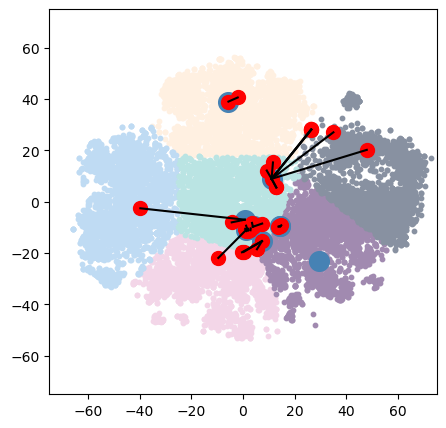

In [31]:
# figure 1a
# Plot the clusters with different colors
plt.figure(figsize=(5, 5))
for cluster in np.unique(labels):
    cluster_points = coordsTSNE[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster], s=10)
# 2010
xc10,yc10=np.array(list(pos[i] for i in jys[newj][2010])).T
plt.scatter(xc10,yc10,color='steelblue', s=200)#, marker="x")
#2018
xc18,yc18=np.array(list(pos[i] for i in jys[newj][2018] if i in pos)).T
plt.scatter(xc18,yc18,color='red', s=100)#, marker="o", facecolor="none")
# linking new skills to nearest old skills
for i,j in dictpairb.items():
    xi,yi = pos[i]
    xj,yj= pos[j]
    plt.plot([xi,xj],[yi, yj], color='k', zorder=10)

plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig1/Fig1P1_FoodBatchmakers_6c_s666_perplex100.pdf') 
plt.show()

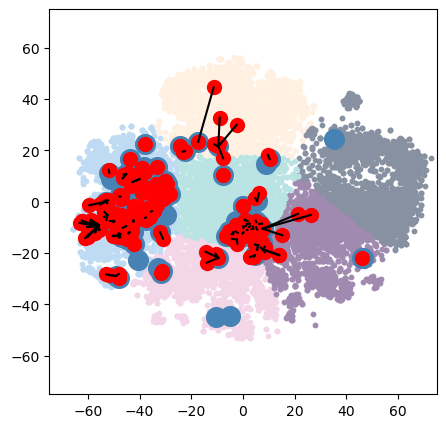

In [29]:
# figure 1b
# Plot the clusters with different colors
plt.figure(figsize=(5, 5))
for cluster in np.unique(labels):
    cluster_points = coordsTSNE[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster], s=10)

#2010
xc10,yc10=np.array(list(pos[i] for i in jys["Computer Programmers"][2010])).T
plt.scatter(xc10,yc10,color='steelblue', s=200)#, marker="x")
# 2018
xc18,yc18=np.array(list(pos[i] for i in jys["Computer Programmers"][2018] if i in pos)).T
plt.scatter(xc18,yc18,color='red', s=100)#, marker="o", facecolor="none")
# linking new skills to nearest old skills
for i,j in dictpairc.items():
    xi,yi = pos[i]
    xj,yj= pos[j]
    plt.plot([xi,xj],[yi, yj], color='k', zorder=10)
    
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig1/Fig1P1_ComputerProgrammers_6c_s666_perplex100.pdf') 
plt.show()

### Figure 1c, d

In [33]:
# with employer job skill data
occ_y_freq=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_npost_emp.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        freq = int(line_lst[2])
        if year == 2010 or year==2018:
            occ_y_freq[job][year] = freq

occ_y_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
occ_y_sfreq=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_skill_freq_emp.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if year in jyn[job]:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    occ_y_skill_freq[job][year][skill] = float(skill_tfidf.split('_')[1])
                    occ_y_sfreq[job][year] += float(skill_tfidf.split('_')[1])

# weights
jw1 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if 2010 in occ_y_sfreq[j] and 2018 in occ_y_sfreq[j]:
            jw1[j] = (occ_y_sfreq[j][2010] / occ_y_sfreq[j][2018]) / (occ_y_freq[j][2010]/occ_y_freq[j][2018])
            if jw1[j] > 1:
                jw1[j] = 1
                    
# skill probability
jysp = copy.deepcopy(occ_y_skill_freq)
for j in jysp:
    if j in occ_y_freq:
        for y in jysp[j]:
            if y in occ_y_freq[j]:
                for s in jysp[j][y].keys():
                    jysp[j][y][s] = jysp[j][y][s]/occ_y_freq[j][y]

In [34]:
# Deming's measurement (sample with non-missing employer): Food Batchmakers and Computer Programers
def skill_change(j, jysp, jw1):
    
    bc={}
    if 2010 in jysp[j] and 2018 in jysp[j]:
        # get the union of skills of 2 years
        alls = set(jysp[j][2010].keys()).union(set(jysp[j][2018].keys()))
        # skill probability change
        for s in alls:
            bc[s] = abs(jysp[j][2018][s] - jysp[j][2010][s]) * jw1[j]
            
    return bc

In [179]:
# Deming and Noray's measure of skill probability change
occsc80_1['Food Batchmakers'], occsc80_1["Computer Programmers"]

(2.708437305486499, 7.452889431122576)

In [180]:
# decompose change to each skill
cc=skill_change("Computer Programmers", jysp, jw1)
bc=skill_change('Food Batchmakers', jysp, jw1)
len(bc), len(cc)

(915, 6875)

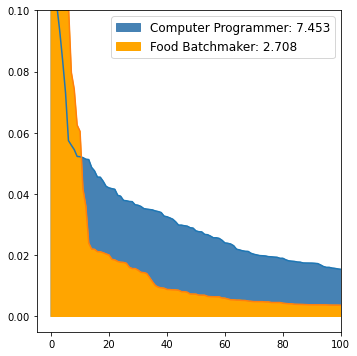

In [277]:
# Figure 1c
fig = plt.figure(figsize=(5,5))

# computer programmer
ax1 = fig.add_subplot(111)
sc=sorted(cc.values(), reverse=True)
plt.plot(sc)
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 7.453")
sb = sorted(bc.values(), reverse=True)
plt.plot(sb)
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmaker: 2.708")
plt.legend(fontsize=12)
#plt.ylabel("Change in probability", fontsize=18)
#plt.xlabel("Decreasing rank of skills", fontsize=18)
plt.tight_layout()
plt.xlim(-5,100)
plt.ylim(-0.005,0.1)

plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig1/Fig1skillprob.pdf')

In [39]:
# change induced by Food Batchmakers new skills: 
scB = {}
newj='Food Batchmakers'
for ns in jys[newj][2018]:
    if ns not in jys[newj][2010]:
        # a new job vector without having the focal new skill
        newv = np.mean([model.wv[s] for s in jys[newj][2018] if s in model.wv and s != ns],axis=0)
        # job skill vector change without the presence of the focal new skill
        newc = 1- np.dot(newv, jyv[newj][2010])/(
            np.linalg.norm(newv)* np.linalg.norm(jyv[newj][2010]))
        scB[ns] = abs(jtr[newj] - newc)

In [40]:
# Change induced by Food Batchmakers old(dropped) skills:
soB = {}
newj='Food Batchmakers'
for ns in jys[newj][2010]:
    if ns not in jys[newj][2018]:
        # a new old vector without having the focal old(dropped) skill
        oldv = np.mean([model.wv[s] for s in jys[newj][2010] if s in model.wv and s != ns],axis=0)
        # job skill vector change without the presence of the focal old skill
        newc = 1- np.dot(oldv, jyv[newj][2018])/(
            np.linalg.norm(oldv)* np.linalg.norm(jyv[newj][2018]))
        soB[ns] = abs(jtr[newj] - newc)

In [41]:
# change induced by Computer programmer new skills: 
scC = {}
for ns in jys["Computer Programmers"][2018]:
    if ns not in jys["Computer Programmers"][2010]:
        newv = np.mean([model.wv[s] for s in jys["Computer Programmers"][2018] if s in model.wv and s != ns],axis=0)
        newc = 1- np.dot(newv, jyv["Computer Programmers"][2010])/(
            np.linalg.norm(newv)* np.linalg.norm(jyv["Computer Programmers"][2010]))
        scC[ns] = abs(jtr["Computer Programmers"] - newc)

In [42]:
# change induced by Computer programmer old(dropped) skills: 
soC = {}
for ns in jys["Computer Programmers"][2010]:
    if ns not in jys["Computer Programmers"][2018]:
        oldv = np.mean([model.wv[s] for s in jys["Computer Programmers"][2010] if s in model.wv and s != ns],axis=0)
        newc = 1- np.dot(oldv, jyv["Computer Programmers"][2018])/(
            np.linalg.norm(oldv)* np.linalg.norm(jyv["Computer Programmers"][2018]))
        soC[ns] = abs(jtr["Computer Programmers"] - newc)

In [192]:
# new skill change and old skll change
sum(scB.values()), sum(scC.values()), sum(soB.values()), sum(soC.values())

(0.050115108489990234,
 0.02186340093612671,
 0.016377389430999756,
 0.005195677280426025)

In [264]:
# sum of approximated decomposition
sum(scB.values())+sum(soB.values()),sum(scC.values())+ sum(soC.values()) 

(0.06649249792098999, 0.027059078216552734)

In [43]:
# actual change, used as label in paper
jtr['Food Batchmakers'], jtr["Computer Programmers"]

(0.08175450563430786, 0.01701796054840088)

In [45]:
# combine old and new skills
saB = {**scB, **soB}
saC = {**scC, **soC}

In [271]:
len(saB), len(saC), len(soB), len(scB), len(soC), len(scC)

(35, 158, 2, 33, 49, 109)

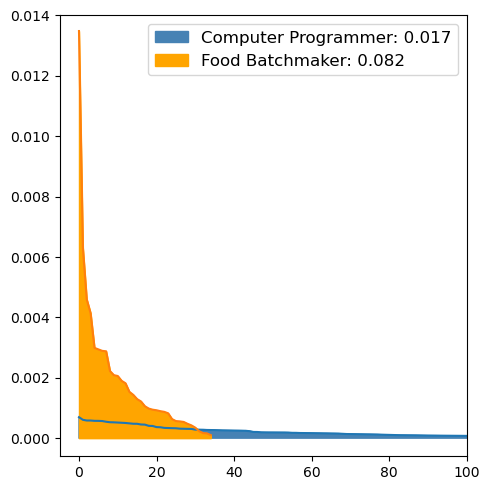

In [46]:
# computer programmer
fig = plt.figure(figsize=(5,5))

sc=sorted(saC.values(), reverse=True)
plt.plot(sc)
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 0.017")
sb = sorted(saB.values(), reverse=True)
plt.plot(sb)
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmaker: 0.082")
plt.legend(fontsize=12)
#plt.ylabel("Change in embedding distance", fontsize=18)
#plt.xlabel("Decreasing rank of skills", fontsize=18)
plt.xlim(-5, 100)
plt.ylim(-0.0006, 0.014)
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig1/Fig1skillembcombine.pdf')

## Figure 2

In [47]:
# calculate CI using bootstrap
def calculateCI2(data,method,n, k):
    m=int(len(data)*k) #take 10% data
    ms=[]
    for j in range(n): #number of samples
        if method=='mean':
                ms.append(np.mean(np.random.choice(data,m)))
        if method=='median':
                ms.append(np.median(np.random.choice(data,m)))
    a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
    
    return (b-a)/2

In [49]:
# job vector change measurement
dfsni_jv = pd.DataFrame(columns=['skill#', "skillchange"])
data = []
for o in osn:
    if o in jtr:
        data.append({'skill#': osn[o], "skillchange": jtr[o]})

# Use pd.concat() instead of append
dfsni_jv = pd.concat([dfsni_jv, pd.DataFrame(data)], ignore_index=True)

dfsni_jv['skill#_bins'] = pd.cut(x=dfsni_jv['skill#'], bins=list(range(0, 90, 10)))
snkeys_jv = [str(k) for k in list(dfsni_jv.groupby(['skill#_bins']).groups.keys())]
xsn_pos = np.arange(len(snkeys_jv))
snmeans_jv = list(dfsni_jv.groupby(['skill#_bins'])['skillchange'].mean())
snstd_jv = list(dfsni_jv.groupby(['skill#_bins'])['skillchange'].apply(calculateCI2, method="mean", n=50, k=0.8))

/var/folders/gl/g3xsl_397tg4jsr3yxz4wmjw0000gq/T/ipykernel_2164/1579002456.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfsni_jv = pd.concat([dfsni_jv, pd.DataFrame(data)], ignore_index=True)
/var/folders/gl/g3xsl_397tg4jsr3yxz4wmjw0000gq/T/ipykernel_2164/1579002456.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  snkeys_jv = [str(k) for k in list(dfsni_jv.groupby(['skill#_bins']).groups.keys())]
/var/folders/gl/g3xsl_397tg4jsr3yxz4wmjw0000gq/T/ipykernel_2164/1579002456.py:14: FutureWarning: The default of observed=False is deprecated and wi

In [ ]:
# edu and job change
ei = defaultdict(lambda:[])
for o in oe:
    if o in jtr:
        if oe[o] < 13:
            ei["high school"].append(jtr[o])
        elif 13 <= oe[o] < 15:
            ei["Associate"].append(jtr[o])
        elif 15 <= oe[o] < 16.5:
            ei["Bachelor"].append(jtr[o])
        else:
            ei["Master/Doctoral"].append(jtr[o])

ekeys = ['high school', 'Associate', 'Bachelor', 'Master/Doctoral']
emeans = [np.mean(ei[key]) for key in ekeys]
estd = [calculateCI2(ei[key],'mean',50, 0.8) for key in ekeys]
xe_pos = np.arange(len(ekeys))

        
# pay and job change
pi = defaultdict(lambda:[])
for o in op:
    if o in jtr:
        if op[o] <= 40000:
            pi["<= 40K"].append(jtr[o])
        elif 40000 <= op[o] < 80000:
            pi["40k-80k"].append(jtr[o])
        else:
            pi[">80k"].append(jtr[o])

pkeys = ['<= 40K', '40k-80k', '>80k']
pmeans = [np.mean(pi[key]) for key in pkeys]
pstd = [calculateCI2(pi[key],'mean',50, 0.8) for key in pkeys]
#pstd = calculateCI2(pi,'mean',50, pkeys, 0.8)
xp_pos = np.arange(len(pkeys))

In [88]:
# correlation between education and job skill change
esc = {}
esc_cat = {}
for o in oe:
    if o in jtr:
        esc[o] = (oe[o], jtr[o])
        esc_cat[o] = (round(oe[o]), jtr[o])
        
x1,y1 = zip(*list(esc.values()))
corr2=pearsonr(x1, y1)
x1c,y1c = zip(*list(esc_cat.values()))
corrsp = spearmanr(x1c, y1c)
print(corr2)
print(corrsp)

(-0.18460347422757495, 5.999664437871287e-07)
SpearmanrResult(correlation=-0.2985531825261429, pvalue=2.608196227340753e-16)


In [20]:
# correlation between pay and job skill change
psc = {}
for o in op:
    if o in jtr:
        psc[o] = (op[o], jtr[o])

x1,y1 = zip(*list(psc.values()))
corr2=pearsonr(x1, y1)
print(corr2)

(-0.12269245756169325, 0.0009626072613207438)


In [22]:
# correlation between skill number and job skill change
snsc = {}
for o in osn:
    if o in jtr:
        snsc[o] = (np.log(osn[o]), jtr[o])
        
x1,y1 = zip(*list(snsc.values()))
corr2=pearsonr(x1, y1)
print(corr2)

(-0.6644466553623556, 8.857483645309603e-94)


In [120]:
# occupation group median stability
gsta = {}
for g in go:
    #gsta[g] = np.median([jtr[j] for j in go[g] if j in jtr and jtr[j] >= gol[g]])
    gsta[g] = np.median([jtr[j] for j in go[g] if j in jtr])

gsta = dict(sorted(gsta.items(), key=operator.itemgetter(1), reverse=True))

df = pd.DataFrame(columns = ["occupation","group", "stability"])
occ=[]
gr=[]
sta=[]
for g in gsta:
    for j in go[g]:
        if j in jtr:
            occ.append(j)
            gr.append(g[:-12])
            sta.append(jtr[j])
        
df["occupation"] = occ
df["group"] = gr
df["stability"] = sta

data=defaultdict(lambda:[])
for i,j in zip(df['group'], df['stability']):
    data[i].append(j) 

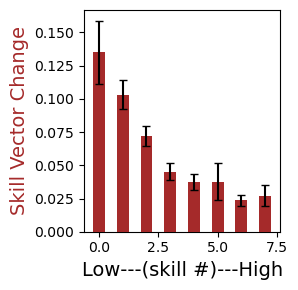

In [50]:
# skill number and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax1 = fig.add_subplot(111)
f3_ax1.bar(xsn_pos, snmeans_jv, width = 0.5, yerr=snstd_jv, color = "brown", align='center', 
           alpha=1, ecolor='black', capsize=3, zorder=10)
f3_ax1.set_ylabel('Skill Vector Change', color = "brown", fontsize=14) 
# x as index of ordered skill number range group: 0-10, 10-20...80-90
f3_ax1.yaxis.set_tick_params(labelsize=10)
f3_ax1.set_xlabel('Low---(skill #)---High', fontsize=14)
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig2/Fig2P1.pdf')

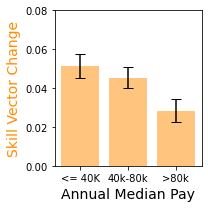

In [133]:
# pay and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax3 = fig.add_subplot(111)
f3_ax3.bar(xp_pos, pmeans, yerr=pstd, color = 'darkorange', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax3.set_ylabel('Skill Vector Change', color = 'darkorange', fontsize=14)
f3_ax3.set_xlabel('Annual Median Pay', fontsize=14)
f3_ax3.set_xticks(xp_pos)
f3_ax3.set_xticklabels(pkeys,size=10)
#plt.xticks(rotation=30)
f3_ax3.yaxis.set_tick_params(labelsize=10)
plt.ylim(0,0.08)
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig2/Fig2P2.pdf')

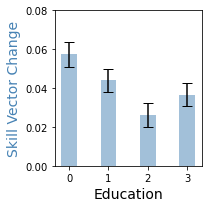

In [43]:
# education and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xe_pos, emeans, yerr=estd, width = 0.4, color = 'steelblue', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax2.set_ylabel('Skill Vector Change', color = 'steelblue', fontsize=14)
f3_ax2.set_xlabel('Education', fontsize=14)
f3_ax2.set_xticks(xe_pos)
#f3_ax2.set_xticklabels(ekeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
#plt.xticks(rotation=30)
plt.ylim(0,0.08)
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig2/Fig2P3.pdf')

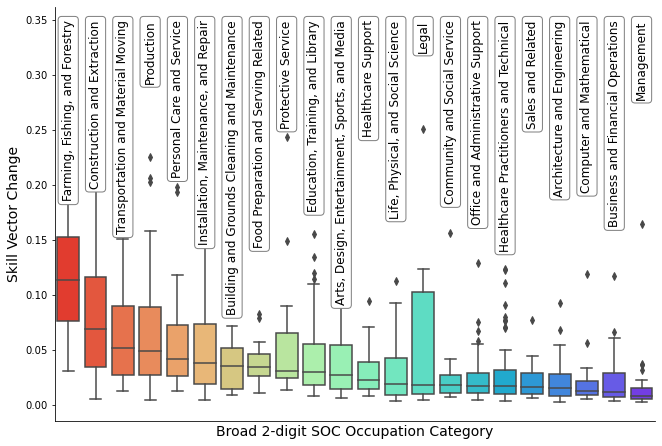

In [147]:
fig = plt.figure(figsize=(9, 6),facecolor='white')

f3_ax4 = fig.add_subplot(111)

f3_ax4= sns.boxplot(y="stability", x="group", data=df, palette="rainbow_r")
#f3_ax4.set_ylim(0,0.2)
#ax.set_title("Job Stability Index",fontsize=22)
f3_ax4.set_ylabel("Skill Vector Change",fontsize=14)
f3_ax4.set_xlabel("Broad 2-digit SOC Occupation Category",fontsize=14)
f3_ax4.set_xticks([])
f3_ax4.yaxis.set_tick_params(labelsize=10)
names= list(data.keys())
for i in range(len(data.keys())):
    #name = " ".join(names[i].split()[:3]) + "\n" + " ".join(names[i].split()[3:])
    name=names[i]
    f3_ax4.text(i, 0.35, name, rotation=90, ha='center', va="top", fontsize=12,
           bbox=dict(boxstyle="round",
                   ec="grey",#(1., 0.5, 0.5),
                   fc='white',
                   ))
sns.despine()
plt.subplots_adjust(hspace=0.0)
plt.tight_layout(pad=0)

plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig2/Fig2P4.pdf')

## Figure 3

### Company: Fig 3a,b

In [18]:
jylsd = defaultdict(lambda:defaultdict(lambda:0))
yjlsd = defaultdict(lambda:defaultdict(lambda:0))
lcjtr = {}
scjtr= {}
for j in lcjyv:
    if j in scjyv and j in jyn:
        if 2010 in lcjyv[j] and 2018 in lcjyv[j] and 2010 in scjyv[j] and 2018 in scjyv[j] and jyn[j][2010] > 100 and jyn[j][2018] > 100:
            jylsd[j][2010] = 1- np.dot(lcjyv[j][2010], scjyv[j][2010])/(np.linalg.norm(lcjyv[j][2010])* np.linalg.norm(scjyv[j][2010]))
            jylsd[j][2018] = 1- np.dot(lcjyv[j][2018], scjyv[j][2018])/(np.linalg.norm(lcjyv[j][2018])* np.linalg.norm(scjyv[j][2018]))
            yjlsd[2010][j] = jylsd[j][2010]
            yjlsd[2018][j] = jylsd[j][2018]
            lcjtr[j] = 1 - np.dot(lcjyv[j][2018], lcjyv[j][2010])/(np.linalg.norm(lcjyv[j][2018])* np.linalg.norm(lcjyv[j][2010]))
            scjtr[j] = 1 - np.dot(scjyv[j][2018], scjyv[j][2010])/(np.linalg.norm(scjyv[j][2018])* np.linalg.norm(scjyv[j][2010]))

In [19]:
len(jylsd), len(lcjtr), len(scjtr)

(556, 556, 556)

In [21]:
# average skill change of large and small company from 2010 to 2018
np.mean(list(lcjtr.values())), np.mean(list(scjtr.values()))

(0.04373546137655382, 0.07546289179393713)

In [23]:
# t test for the difference between average skill change of large and small company from 2010 to 2018
stats.ttest_rel(list(lcjtr.values()), list(scjtr.values()))

Ttest_relResult(statistic=-12.504636702472864, pvalue=8.73625478162196e-32)

In [20]:
# mean of large and small company distance in 2010 and 2018
np.mean(list(yjlsd[2010].values())), np.mean(list(yjlsd[2018].values()))

(0.08712869148245818, 0.052927221432864234)

In [22]:
# t test for the difference between mean of large and small company distance in 2010 and 2018
stats.ttest_rel(list(yjlsd[2010].values()), list(yjlsd[2018].values()))

Ttest_relResult(statistic=12.113759548261173, pvalue=3.920678520822205e-30)

In [254]:
# prepare data to plot large and small company average change from 2010 to 2018
cmeans = [np.mean(list(lcjtr.values())), np.mean(list(scjtr.values()))]
cstd = [calculateCI2(list(lcjtr.values()),'mean',50, 0.8), calculateCI2(list(scjtr.values()),'mean',50, 0.8)]
xc_pos = np.arange(len(cmeans))
ckeys = ['large', 'small']

# prepare data to plot the large and small company difference in 2010 and 2018
ymeans = [np.mean(list(yjlsd[2010].values())), np.mean(list(yjlsd[2018].values()))]
ystd = [calculateCI2(list(yjlsd[2010].values()),'mean',50, 0.8), calculateCI2(list(yjlsd[2018].values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']

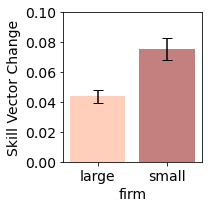

In [255]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f1 = fig.add_subplot(111)
f1.bar(xc_pos[0], cmeans[0], yerr=cstd[0], color = 'lightsalmon', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.bar(xc_pos[1], cmeans[1], yerr=cstd[1], color = 'darkred', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.set_ylabel('Skill Vector Change', fontsize=14)
f1.set_xlabel('firm', fontsize=14)
f1.set_xticks(xc_pos)
f1.set_xticklabels(ckeys,size=14)
f1.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("2010 vs. 2018")
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig3/Fig3firmchange.pdf')

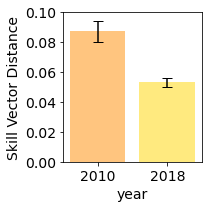

In [237]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f2 = fig.add_subplot(111)
f2.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'darkorange', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.set_ylabel('Skill Vector Distance', fontsize=14)
f2.set_xlabel('year', fontsize=14)
f2.set_xticks(xy_pos)
f2.set_xticklabels(ykeys,size=14)
f2.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("large vs. small firm")

plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig3/Fig3firmdiff.pdf')

### Market: Fig 3c,d

In [41]:
jylslocd = defaultdict(lambda:defaultdict(lambda:0))
yjlslocd = defaultdict(lambda:defaultdict(lambda:0))
llocjtr = {}
slocjtr= {}
for j in llocjyv:
    if j in slocjyv and j in jyn:
        if 2010 in llocjyv[j] and 2018 in llocjyv[j] and 2010 in slocjyv[j] and 2018 in slocjyv[j] and jyn[j][2010] > 100 and jyn[j][2018] > 100:
            jylslocd[j][2010] = 1- np.dot(llocjyv[j][2010], slocjyv[j][2010])/(np.linalg.norm(llocjyv[j][2010])* np.linalg.norm(slocjyv[j][2010]))
            jylslocd[j][2018] = 1- np.dot(llocjyv[j][2018], slocjyv[j][2018])/(np.linalg.norm(llocjyv[j][2018])* np.linalg.norm(slocjyv[j][2018]))
            yjlslocd[2010][j] = jylslocd[j][2010]
            yjlslocd[2018][j] = jylslocd[j][2018]
            llocjtr[j] = 1 - np.dot(llocjyv[j][2018], llocjyv[j][2010])/(np.linalg.norm(llocjyv[j][2018])* np.linalg.norm(llocjyv[j][2010]))
            slocjtr[j] = 1 - np.dot(slocjyv[j][2018], slocjyv[j][2010])/(np.linalg.norm(slocjyv[j][2018])* np.linalg.norm(slocjyv[j][2010]))

In [42]:
len(jylslocd), len(llocjtr), len(slocjtr)

(625, 625, 625)

In [43]:
# average skill change of large and small market from 2010 to 2018
np.mean(list(llocjtr.values())), np.mean(list(slocjtr.values()))

(0.04947633752822876, 0.07788015079498291)

In [44]:
# t test for the difference between average skill change of large and small market from 2010 to 2018
stats.ttest_rel(list(llocjtr.values()), list(slocjtr.values()))

Ttest_relResult(statistic=-11.901989607306222, pvalue=1.400902066484937e-29)

In [45]:
# mean of large and small market distance in 2010 and 2018
np.mean(list(yjlslocd[2010].values())), np.mean(list(yjlslocd[2018].values()))

(0.05525299425125122, 0.03757993698120117)

In [46]:
# t test for the difference between mean of large and small market distance in 2010 and 2018
stats.ttest_rel(list(yjlslocd[2010].values()), list(yjlslocd[2018].values()))

Ttest_relResult(statistic=7.803104136749592, pvalue=2.5531700505919495e-14)

In [252]:
# prepare data to plot large and small market average change from 2010 to 2018
cmeans = [np.mean(list(llocjtr.values())), np.mean(list(slocjtr.values()))]
cstd = [calculateCI2(list(llocjtr.values()),'mean',50, 0.8), calculateCI2(list(slocjtr.values()),'mean',50, 0.8)]
xc_pos = np.arange(len(cmeans))
ckeys = ['large', 'small']

# prepare data to plot the large and small market difference in 2010 and 2018
ymeans = [np.mean(list(yjlslocd[2010].values())), np.mean(list(yjlslocd[2018].values()))]
ystd = [calculateCI2(list(yjlslocd[2010].values()),'mean',50, 0.8), calculateCI2(list(yjlslocd[2018].values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']

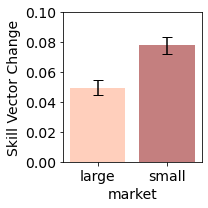

In [253]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f1 = fig.add_subplot(111)
f1.bar(xc_pos[0], cmeans[0], yerr=cstd[0], color = 'lightsalmon', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.bar(xc_pos[1], cmeans[1], yerr=cstd[1], color = 'darkred', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.set_ylabel('Skill Vector Change', fontsize=14)
f1.set_xlabel('market', fontsize=14)
f1.set_xticks(xc_pos)
f1.set_xticklabels(ckeys,size=14)
f1.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("2010 vs. 2018")
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig3/Fig3marketchange.pdf')

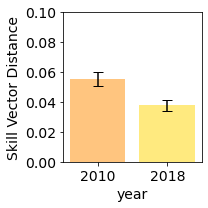

In [240]:
fig = plt.figure(figsize=(3, 3),facecolor='white')

f2 = fig.add_subplot(111)
f2.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'darkorange', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.set_ylabel('Skill Vector Distance', fontsize=14)
f2.set_xlabel('year', fontsize=14)
f2.set_xticks(xy_pos)
f2.set_xticklabels(ykeys,size=14)
f2.yaxis.set_tick_params(labelsize=14)
plt.ylim(0,0.1)
#plt.title("large vs. small market")

plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig3/Fig3marketdiff.pdf')

### US map: Fig 3e

In [53]:
# location - job - post number
Year2018=defaultdict(lambda:defaultdict(lambda:0))
locsize18=defaultdict(lambda:0)
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_jobid_cz_occ.txt','r') as f:
    for line in f:
        linelst=line[:-1].split('\t')
        year=int(linelst[0])
        if year ==2018: 
            occ=linelst[2]
            cz=float(linelst[3])
            if occ !='na':
                Year2018[cz][occ] += 1
                locsize18[cz]+=1
len(Year2018), len(locsize18), np.percentile(list(locsize18.values()), [90])[0]

(658, 658, 83364.70000000007)

In [54]:
# skill change score for each cz
Cscore={}
n=0
SizePerc90=round(np.percentile(list(locsize18.values()), [90])[0])
for town in Year2018:
    n+=1
    if n%100==0:
        flushPrint(n/100)
    if town in locsize18:
        # get rid of outliers
        if 100 < locsize18[town]: #100 < < 10000:
            # use different dictionary for different location
            if locsize18[town]>SizePerc90:
                dic=llocjtr
            else:
                dic=slocjtr
            # more than three jobs per town
            if len(Year2018[town])>=3:
                jp=defaultdict(lambda:0)
                for j in Year2018[town]:
                    if j in dic:
                        jp[j]+=Year2018[town][j]
                s=sum([v for v in jp.values()])
                jp=dict((k,v/s) for k,v in jp.items())
                c_score=sum([dic[i]*jp[i] for i in jp])
                Cscore[town]=c_score

6

In [58]:
czcha = {'LM_Code': list(Cscore.keys()), 'change': list(Cscore.values())}
czcha_df=pd.DataFrame(data=czcha)
czcha_df.to_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/CZChange.csv')
len(Cscore)

652

In [143]:
# us commuting zone data
czs = geopandas.read_file('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/ERS10.geojson')
print(len(czs))
# append change to this dataframe
czs = czs.merge(czcha_df, how='inner', on='LM_Code')
czs = czs[['LM_Code', 'change', 'geometry']]
print(len(czs))

658
652


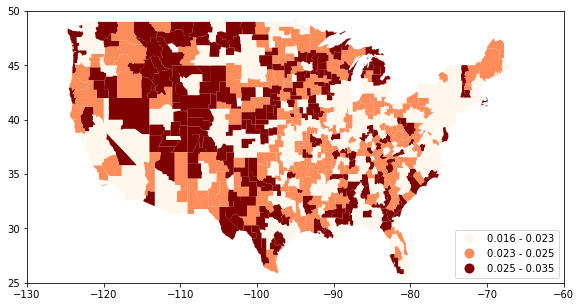

In [144]:
# cz - average job skill change in three quantiles
fig, ax = plt.subplots(1, 1,figsize=(10, 5))

czs.plot(column='change', ax=ax, legend=True, cmap='OrRd', figsize=(20, 20), scheme='quantiles', k=3, legend_kwds={'loc': 'lower right'})
plt.xlim(-130,-60)
plt.ylim(25, 50)

# get all upper bounds
upper_bounds = mapclassify.Quantiles(czs.change, k=3).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = czs.change.min()
    else:
        lower_bound = upper_bounds[index-1]
    # format the numerical legend here
    bound = f'{lower_bound:.3f} - {upper_bound:.3f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
    
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig3/Fig3cz.pdf')

In [244]:
# us state geometry data
states = geopandas.read_file(
    '/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/usmap/usa-states-census-2014.shp')

statematch = []
statechas = defaultdict(lambda:[])
for cz, ind, cha in zip(czs['geometry'], czs['LM_Code'], czs['change']):
    nv = float('nan')
    czst = {}
    for st, name in zip(states['geometry'], states['NAME']):
        czst[name] = cz.intersection(st).area
        if czst[name]>0:
            statechas[name].append(cha)
    czst = sorted(czst.items(), key=operator.itemgetter(1), reverse=True)
    if czst[0][1]>0:
        nv=czst[0][0]
    statematch.append(nv)
        
czs['NAME'] = statematch
print(len(set(czs['NAME'].dropna())), len(czs[czs['NAME'].isna()]), len(statechas))

48 15 49


In [245]:
# state - average job skill change in three quantiles (cz go with largest intersection)
czs=czs.dropna(subset=['NAME'])
czs = czs.groupby('NAME').mean().reset_index()
states_wcha = states.merge(czs, how='inner', on='NAME')
states_wcha = states_wcha.drop_duplicates(['NAME'])

len(states_wcha), len(states)

(48, 58)

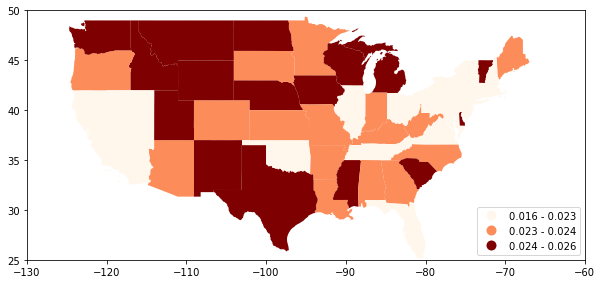

In [247]:
# state - average job skill change in three quantiles (cz go with largest intersection)
fig, ax = plt.subplots(1, 1,figsize=(10, 5))

states_wcha.plot(column='change', ax=ax, legend=True, cmap='OrRd', figsize=(20, 20), scheme='quantiles',
                 k=3, legend_kwds={'loc': 'lower right'})
plt.xlim(-130,-60)
plt.ylim(25, 50)

# get all upper bounds
upper_bounds = mapclassify.Quantiles(states_wcha.change, k=3).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = states_wcha.change.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.3f} - {upper_bound:.3f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig3/Fig3state_czlar.pdf')

### Dempraphic group: Fig 3f,g

In [52]:
# read in social group data
GenderRace=pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/2018_race_gender.xlsx').dropna().reset_index()
# Remove NAs
GenderRace=GenderRace[(GenderRace['Women']!='–') & (GenderRace['White']!='–') & (GenderRace['Hispanic\nor Latino']!='–')]
len(GenderRace)

361

In [55]:
# all job names to lower case for matching
jtr2=dict([(j.lower(), jtr[j]) for j in jtr])
oe2= dict([(j.lower(), oe[j]) for j in oe])
js = [o for o in jtr2 if o in oe2]

# filter overlapping occupations
GenderRace['occupation'] = [occ.lower() for occ in GenderRace['occupation']]
GenderRace = GenderRace[GenderRace['occupation'].isin(js)]
# add skill change
GenderRace['skillchange'] = [jtr2[j] for j in GenderRace['occupation']]

# gender and race employment for each occupation
gocce=defaultdict(lambda:defaultdict(lambda:0))
for a,b,c,d,e,f,g in zip(GenderRace['occupation'], GenderRace['Women'],GenderRace['White'], GenderRace['Black or\nAfrican\nAmerican'], 
            GenderRace['Asian'], GenderRace['Hispanic\nor Latino'], GenderRace['total employment']):
    gocce['women'][a] = b*g/100
    gocce['men'][a] = (100-b)*g/100
    gocce['white'][a] = c*g/100
    gocce['black'][a] = d*g/100
    gocce['asian'][a] = e*g/100
    gocce['latinx'][a] = f*g/100

# calculate the share group employment in each occupation
goccs=defaultdict(lambda:defaultdict(lambda:0))
for g in gocce:
    sume = np.sum(list(gocce[g].values()))
    for o in gocce[g]:
        goccs[g][o] = gocce[g][o] / sume

# occupation - education year
gr_oe = dict((j, oe2[j]) for j in GenderRace['occupation'])
gr_oe = dict(sorted(gr_oe.items(), key=lambda item: item[1]))

In [56]:
# Data preparation for first plot (women vs men employment)
women_employment = []
men_employment = []
for occupation, skilln in gr_oe.items():
    women_employment.extend([skilln] * round(gocce["women"].get(occupation, 0)))
    men_employment.extend([skilln] * round(gocce["men"].get(occupation, 0)))

# Data preparation for second plot (racial groups employment)
emp = defaultdict(lambda: [])
for occupation, skilln in gr_oe.items():
    for g in ['white', 'black', 'asian', 'latinx']:
        emp[g].extend([skilln] * round(gocce[g].get(occupation, 0)))

# Data preparation for third plot (bar plot)
df_rg=pd.DataFrame()
for g in ['women', 'men', 'latinx', 'black','asian','white']:
    skiocc_wsc = defaultdict(lambda:0)
    for o in goccs[g]:
        # skill change weighted by share group employment in occ
        skiocc_wsc[o]=jtr2[o]*goccs[g][o]
    # sum the weighted change for each group by skill level, sort from high to low skill
    df_rg[g] = [np.sum(list(skiocc_wsc.values()))]

# calculate group differences
df_re = df_rg
df_re['women'] = df_re['women'] - df_re['men']
for g in ['latinx', 'black','asian']:
    df_re[g] = df_re[g] - df_re["white"]
df_re = df_re.drop(columns=["men", "white"])
df_melted = df_re.melt(var_name='Group', value_name='Weighted Average Skill Change')
colors = {'women': 'orange', 'men': 'cornflowerblue', 'white': 'lightseagreen', 'latinx':'chocolate', 
          'asian': 'yellowgreen', 'black': 'goldenrod'}
df_melted['Color'] = df_melted['Group'].apply(lambda x: colors[x])

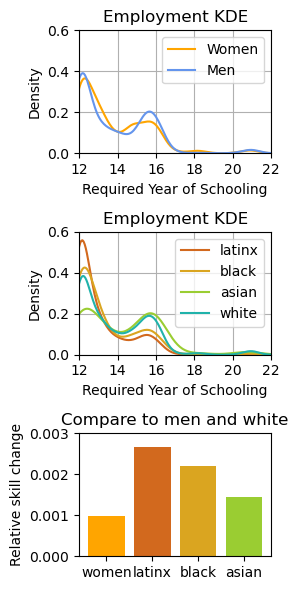

In [57]:
fig, axes = plt.subplots(3, 1, figsize=(3, 6))

# First plot: KDE for men and women
sns.kdeplot(women_employment, label="Women", bw_adjust=2, ax=axes[0], color=colors['women'])
sns.kdeplot(men_employment, label="Men", bw_adjust=2, ax=axes[0], color=colors['men'])
axes[0].set_xlabel("Required Year of Schooling")
axes[0].set_ylabel("Density")
axes[0].set_title("Employment KDE")
axes[0].set_xlim(12, 22)
axes[0].set_xticks([12, 14, 16, 18, 20,22])
axes[0].set_ylim(0, 0.6)
axes[0].legend()
axes[0].grid(True)

# Second plot: KDE for racial groups
for g in ['latinx', 'black', 'asian', 'white']:
    sns.kdeplot(emp[g], label=g, bw_adjust=2, ax=axes[1], color=colors[g])
axes[1].set_xlabel("Required Year of Schooling")
axes[1].set_ylabel("Density")
axes[1].set_title("Employment KDE")
axes[1].set_xlim(12, 22)
axes[1].set_xticks([12, 14, 16, 18, 20,22])
axes[1].set_ylim(0, 0.6)
axes[1].legend()
axes[1].grid(True)

# Third plot: Bar plot of weighted average skill change
axes[2].bar(df_melted['Group'], df_melted['Weighted Average Skill Change'], color=df_melted['Color'])
axes[2].set_ylim(0, 0.003)
axes[2].set_title('Compare to men and white')
axes[2].set_ylabel("Relative skill change")

# Adjust layout
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/Fig3/Fig3_demo_education.pdf')
plt.show()